# Original Code and Paper

- Original code(caffe): https://github.com/richzhang/colorization/blob/master/colorization/demo/colorization_demo_v2.ipynb
- Paper: https://arxiv.org/pdf/1603.08511.pdf

In [21]:
import cv2 # opencv 이미지 프로세싱을 불러온다.
import os #os 모듈을 통해 파일을 관리합니다.
import numpy as np #넘파이 배열을 위해 넘파이 라아브러리를 불러옵니다.
import matplotlib.pyplot as plt #이미지를 나타내기위해 matplot 라이브러리를 사용합니다.


# Prepare Model
- You need to download models from Zhang's server
- Run "get_models.sh" to get it

In [22]:
proto = './models/colorization_deploy_v2.prototxt' #모델의 레이어 구성과 속성 정의합니다.


#weights = './models/colorization_release_v2_norebal.caffemodel'  #version 연한 채색 
weights = './models/colorization_release_v2.caffemodel'  # 학습된 caffe모델(가중치 값)을 불러온다.

#load cluster centers
pts_in_hull = np.load('./models/pts_in_hull.npy')
pts_in_hull = pts_in_hull.transpose().reshape(2, 313, 1, 1).astype(np.float32)


net = cv2.dnn.readNetFromCaffe(proto, weights) #dnn 심층 신경망 네트워크를 생성합니다.


# populate cluster centers as 1x1 convolution kernel
net.getLayer(net.getLayerId('class8_ab')).blobs = [pts_in_hull]
net.getLayer(net.getLayerId('conv8_313_rh')).blobs = [np.full((1, 313), 2.606, np.float32)]

# Preprocessing

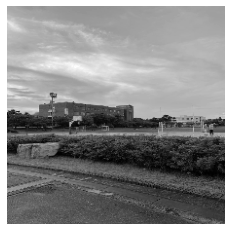

In [23]:
img_path = 'img/2.jpg'         #이미지의 경로를 지정하고 grayscale로 이미지를 불러옵니다.
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
img_input = img.copy()


img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) #흑백 이미지파일을 rgb 값으로 변경한다.                                       
img_rgb = img.copy()

# 사진의 rgb 값을 0~1 사이의 값으로  정규화합니다.
img_rgb = (img_rgb / 255.).astype(np.float32)


img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2Lab) #RGB 색깔체계를 LAB형식으로 바꾼다.

img_l = img_lab[:, :, 0] #L 채널만 사용하기위해 img_l 배열을 선언한다.

input_img = cv2.resize(img_l, (224, 224)) # 모델 input 에 맞추어 사진을 resize 합니다.
input_img -= 50 # input값을 보정하기위해 50을 빼줍니다. 더많은 값을 뺄수록 색이 진해집니다. 

plt.axis('off')
plt.imshow(input_img, cmap='gray') #input 이미지를 grayscale 로 나타냅니다.

# Prediction

True

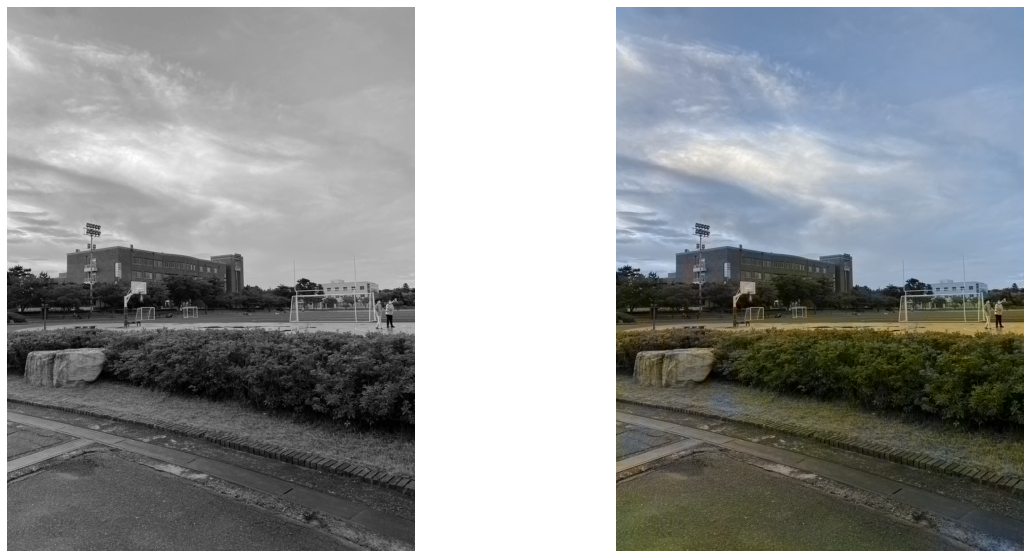

In [24]:
net.setInput(cv2.dnn.blobFromImage(input_img)) 
#이미지의 용량이 크기때문에 2진수 형태의 이미지파일로 설정하고 모델의 input값으로 설정합니다.
pred = net.forward()[0,:,:,:].transpose((1, 2, 0))
#인풋 이미지로 모델을 실행합니다.

pred_resize = cv2.resize(pred, (img.shape[1], img.shape[0]))
# 224 size 의 이미지를 원래 이미지크기로 되돌립니다.



pred_lab = np.concatenate([img_l[:, :, np.newaxis], pred_resize], axis=2)
#L 채널에 pred의 결과 값 두개인 A 채널과 B 채널 값을 병합시킨다.

pred_rgb = cv2.cvtColor(pred_lab, cv2.COLOR_Lab2RGB)
pred_rgb = np.clip(pred_rgb, 0, 1) * 255
pred_rgb = pred_rgb.astype(np.uint8)
# 결과값 LAB 채널을 RGB 값으로 변환시키고 처음에 255로 나누었기때문에,
# 다시 배열 요소에 255를 곱해준다.


fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 2, 1).axis('off')
plt.imshow(img_l, cmap='gray')
fig.add_subplot(1, 2, 2).axis('off')
plt.imshow(pred_rgb)
#최종 결과 이미지를 나타낸다.


filename, ext = os.path.splitext(img_path)
input_filename = '%s_input%s' % (filename, ext)
output_filename = '%s_output%s' % (filename, ext)

pred_rgb_output = cv2.cvtColor(pred_rgb, cv2.COLOR_RGB2BGR)

cv2.imwrite(input_filename, img_input)
cv2.imwrite(output_filename, np.concatenate([img, pred_rgb_output], axis=1))

#인풋이미지와 아웃풋이미지를 비교하는 이미지를 생성한다.